* `Import Libraries`

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import chi2, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

* `Read Dataset`

In [2]:
FILE_PATH = os.path.join(os.getcwd(), "..", "dataset", "churn-data.csv")
df = pd.read_csv(FILE_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# renaming columns
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [4]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# stats
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Drop first 3 features
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

* `EDA`

In [7]:
# Check nans
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
# Geography
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [9]:
# Gender
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [10]:
# Target
df['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [11]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [12]:
# Tenure
df['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

* `Data Vizualization & Handling Outliers`

* `Univariate Viz`

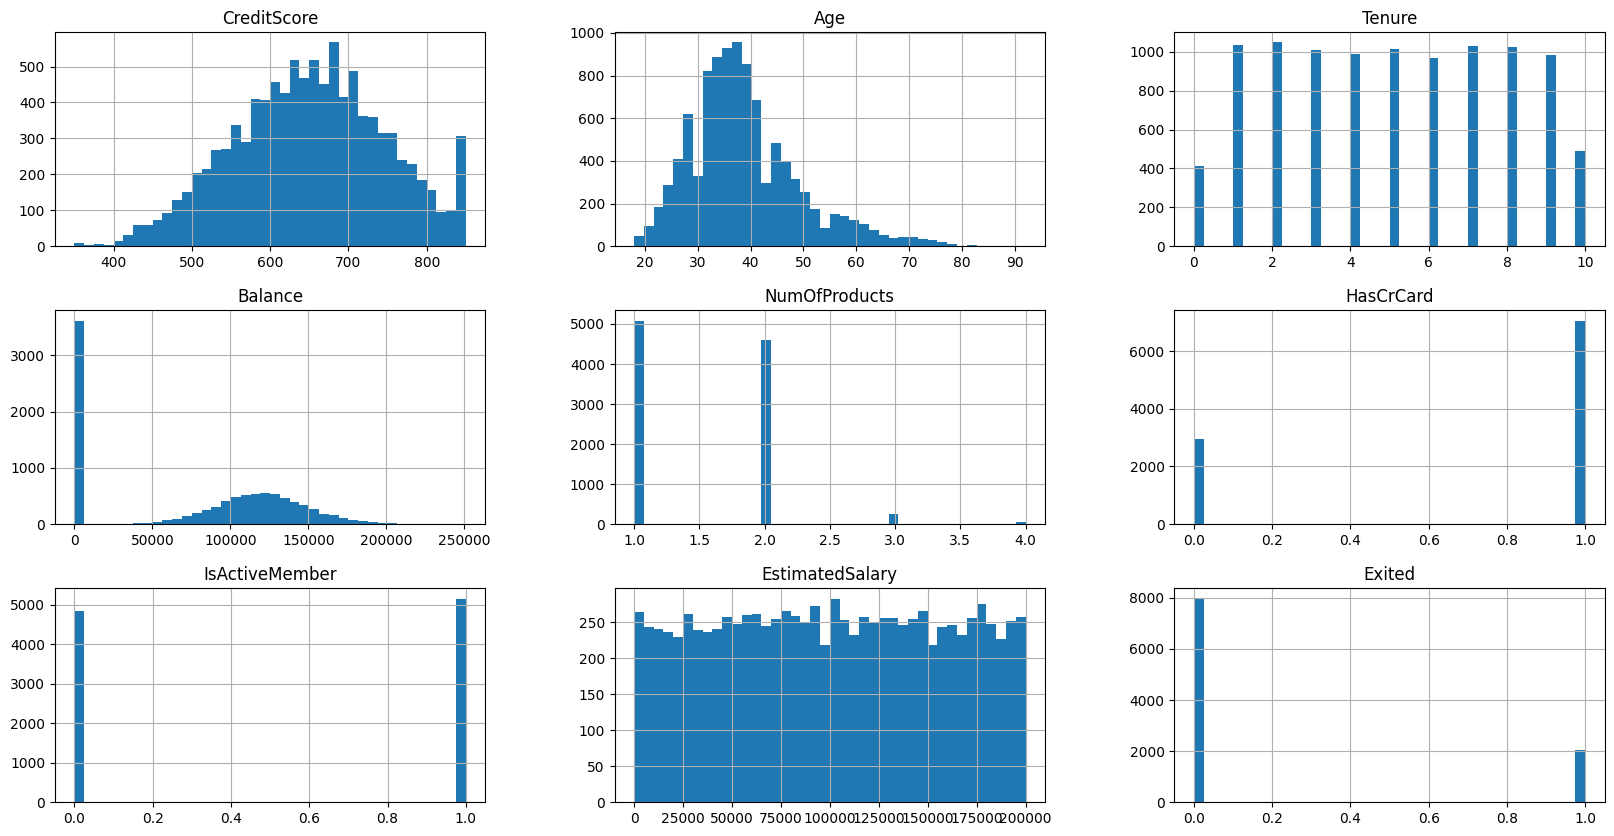

In [13]:
# Numerical hist
df.hist(bins=40, figsize=(20, 10))
plt.show()

In [14]:
# drop some otuliers
df.drop(index=df[df['Age'] > 80].index.tolist(), axis=0, inplace=True)

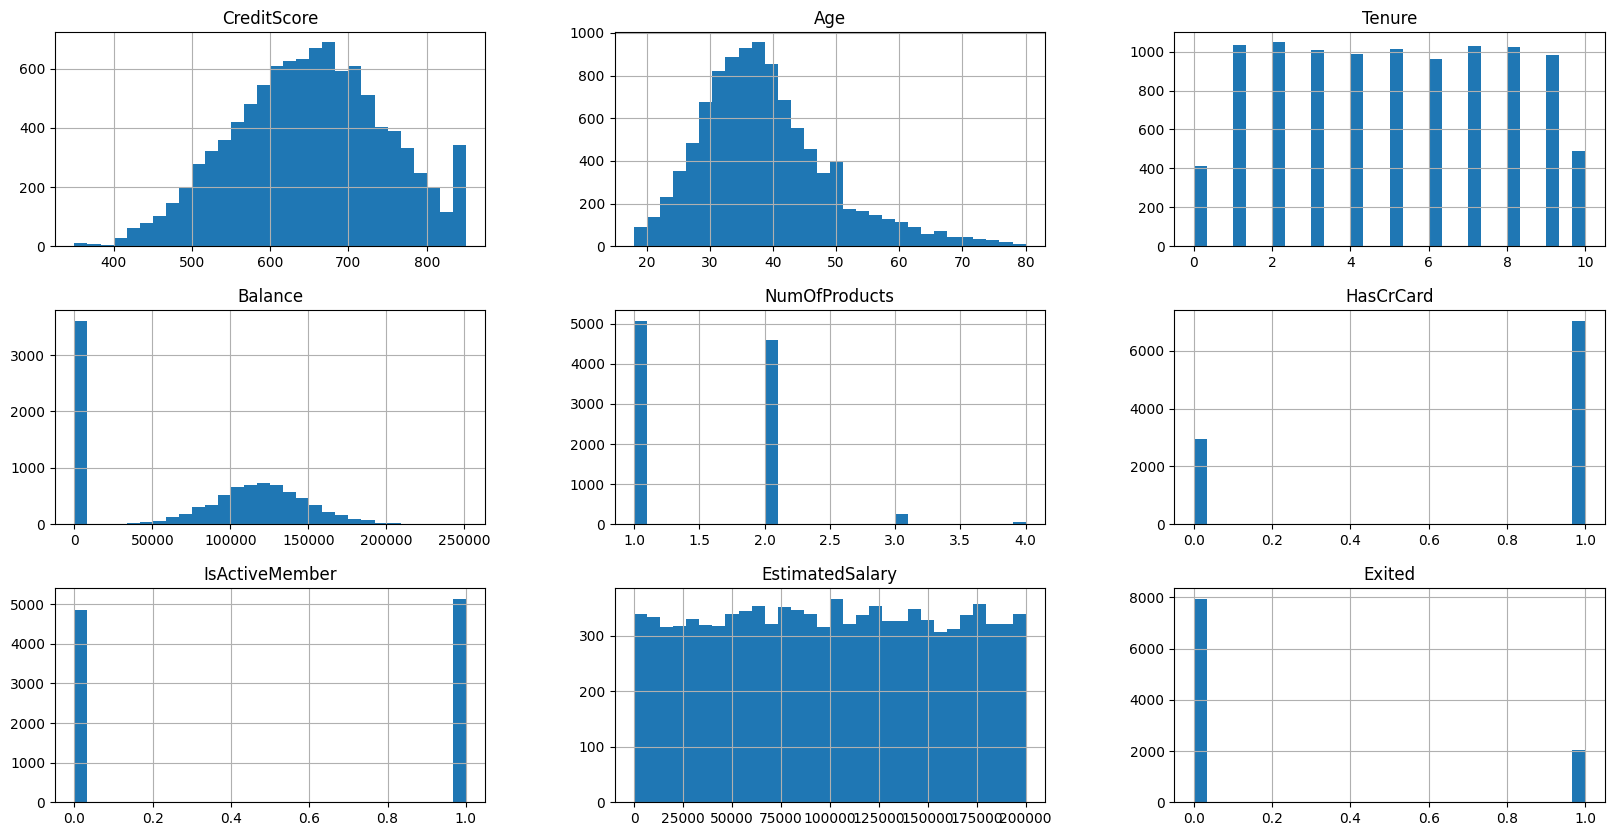

In [15]:
# After: Numerical hist
df.hist(bins=30, figsize=(20, 10))
plt.show()

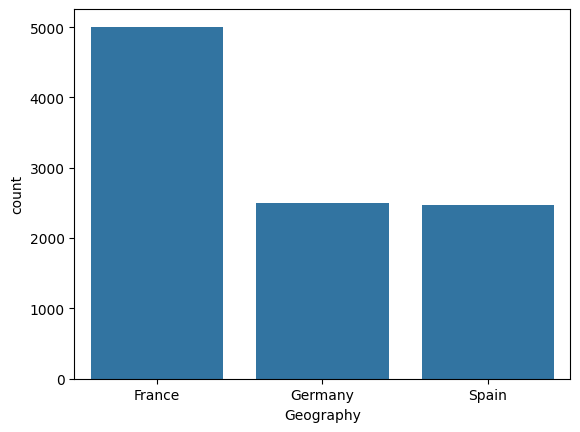

In [16]:
# countplot
sns.countplot(data=df, x='Geography', order=df['Geography'].value_counts().index.tolist())
plt.show()

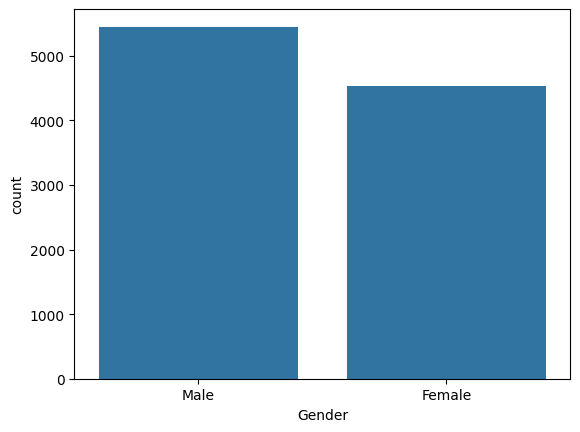

In [17]:
# counplot for Gender
sns.countplot(data=df, x='Gender', order=df['Gender'].value_counts().index.tolist())  ## title, xlabel, ylabel
plt.show()

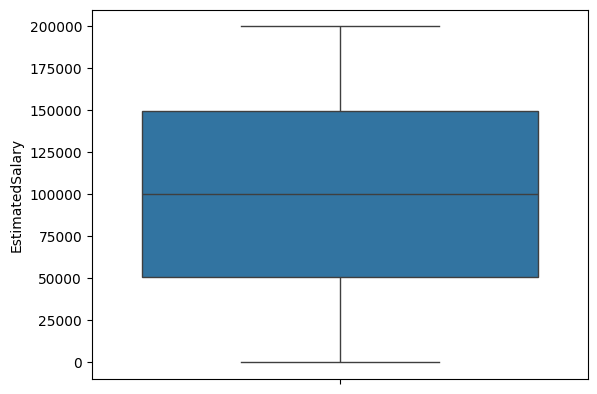

In [18]:
# Boxplot for (EstimatedSalary)
sns.boxplot(data=df, y='EstimatedSalary')
plt.show()

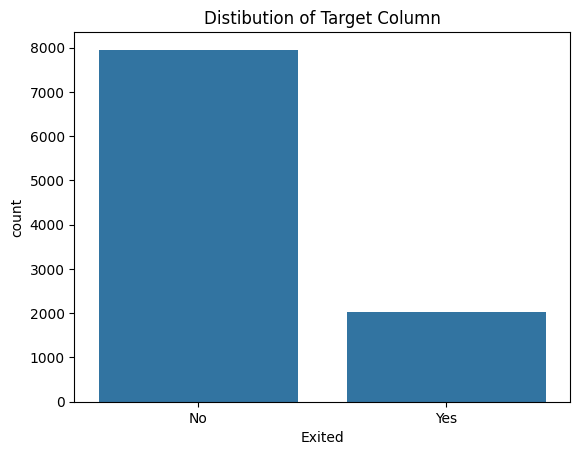

In [19]:
# countplot for Exited
sns.countplot(data=df, x='Exited')
plt.title('Distibution of Target Column')
plt.xticks(labels=["No", "Yes"], ticks=[0, 1])
plt.show()

* `Bivariate Viz`

In [20]:
# for each gender, get the mean of estimatedsalary
df.groupby("Gender")["EstimatedSalary"].mean()

Gender
Female    100575.998277
Male       99671.901194
Name: EstimatedSalary, dtype: float64

<Axes: xlabel='Gender', ylabel='EstimatedSalary'>

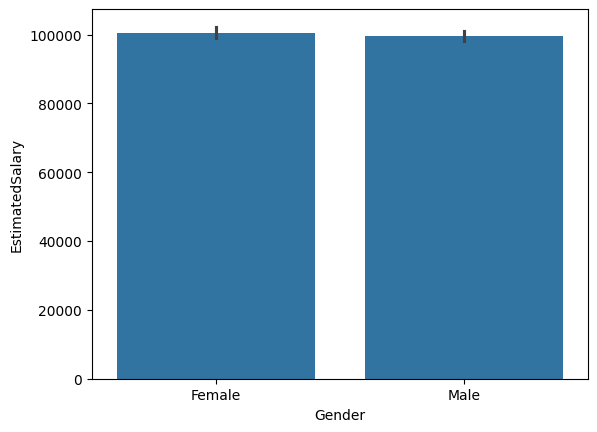

In [21]:
sns.barplot(data=df, x='Gender', y="EstimatedSalary", estimator="mean")

<Axes: xlabel='Tenure', ylabel='count'>

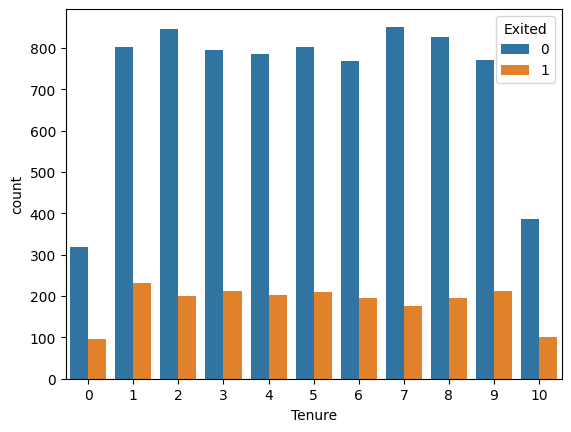

In [22]:
# Relation between Tenure and Exited
sns.countplot(data=df, x='Tenure', hue='Exited')

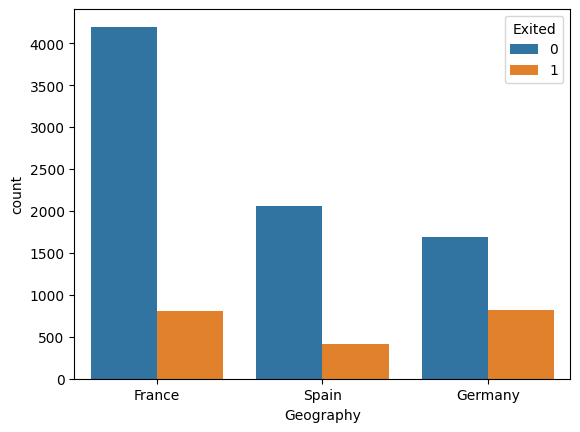

In [23]:
# Geography with Exited
sns.countplot(data=df,x='Geography', hue='Exited')  ## labels, titles
plt.show()

----

* `Split to train & test`

In [24]:
# to X & y
X = df.drop(columns=['Exited'], axis=1)
y = df['Exited']

# to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=45, stratify=y)

# Check shapes
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('***'*10)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (7990, 10)
y_train.shape 	 (7990,)
******************************
X_test.shape 	 (1998, 10)
y_test.shape 	 (1998,)


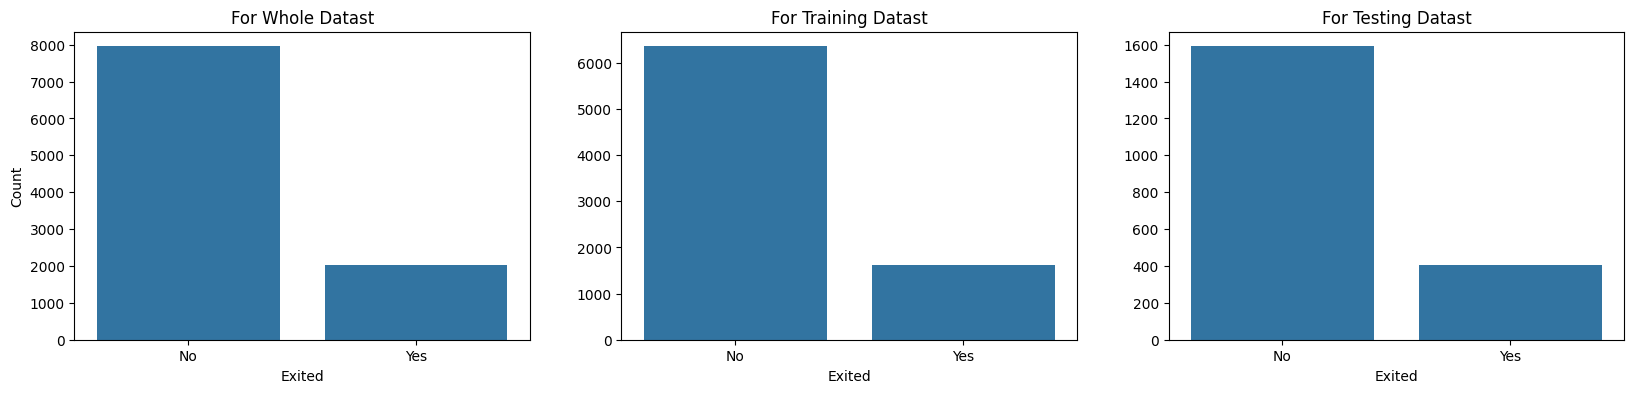

In [25]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

* `Feature Selection & Preprocessing`

In [26]:
# slice cols
num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
categ_cols = ['Geography', 'Gender']
ready_cols = list(set(X_train.columns) - set(num_cols) - set(categ_cols))

In [27]:
ready_cols

['IsActiveMember', 'NumOfProducts', 'HasCrCard', 'Tenure']

In [28]:
# For num_cols with target --> ANOVA
_, p_val = f_classif(X=X_train[num_cols], y=y_train)
p_val # I want to procees with all these features, so assume all p_values < 0.05 --> Recject H0 == there is an association between features and target

array([9.12989970e-002, 1.15359217e-149, 3.56368021e-025, 6.16127881e-001])

In [29]:
# for catge_cols with target --> chi2
_, p_val = chi2(X=OrdinalEncoder().fit_transform(X_train[categ_cols]), y=y_train)
p_val  # p_value ~ 0.05 --> Reject H0 --> There is an association between features and target

array([1.56448286e-03, 5.13986341e-10])

In [30]:
# for ready_cols with target --> chi2
_, p_val = chi2(X=X_train[ready_cols], y=y_train)
p_val  # I want to procees with all these features, so assume all p_values < 0.05 --> Recject H0 == there is an association between features and target

array([7.15759804e-22, 6.55133468e-02, 6.69284702e-01, 6.36015039e-02])

In [31]:
# Pipeline

# Numerical: num_cols --> Imputing using median, and standardization
# Categorical: categ_cols --> Imputing using mode, and OHE
# Ready : read_cols --> Imputig using mode


# For Numerical
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# For Categorical
categ_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(sparse_output=False, drop="first"))
])

# For Ready
ready_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])


# Combine all
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("categ", categ_pipeline, categ_cols),
    ("ready", ready_pipeline, ready_cols)
])

# Apply
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [32]:
X_train_final.shape, y_train.shape

((7990, 11), (7990,))

In [33]:
X_test_final.shape, y_test.shape

((1998, 11), (1998,))

In [34]:
# make a folder for assets
ARTIFACT_FOLDER_PATH = os.path.join(os.getcwd(), "..", "assets")
os.makedirs(ARTIFACT_FOLDER_PATH, exist_ok=True)

In [35]:
# Dump pipeline
joblib.dump(preprocessor, os.path.join(ARTIFACT_FOLDER_PATH, "preprocessor.pkl"))

['c:\\Users\\moham\\Desktop\\Round 2\\07- Chrun Full project\\G4\\notebooks\\..\\artifacts\\preprocessor.pkl']

----

* `Dealing with imbalanced Data`

In [36]:
# 1. Using class_weight for solving imbalanced data
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / sum(vals_count)
dict_weights = {}
for i in range(2):  # 2 classes (0, 1)
    dict_weights[i] = vals_count[i]

# to model
dict_weights

{0: 0.20387984981226537, 1: 0.7961201501877346}

In [37]:
# 2. Using UnderSampling or OverSampling

# Using SMOTE
over = SMOTE(sampling_strategy=0.7, k_neighbors=5, random_state=45)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_final, y_train)

----

* `Building Models`
> Let's consider evaluation using `f1-score`

* `LogisticRegression`

In [38]:
# Using Logistic without considering any method for solving imbalanced
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_final, y_train)

# Predict
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# Evaluate
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 30.965
The f1_score using Logistic model for Testing Dataset is 37.500


In [39]:
# 2. Using logisit -- using class_weight
log_clf = LogisticRegression(C=1.5, class_weight=dict_weights)
log_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# using f1-score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log  = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 49.814
The f1_score using Logistic model for Testing Dataset is 49.915


In [40]:
# 3. Using logisit -- using SMOTE
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_train_log = log_clf.predict(X_train_final)
y_pred_test_log = log_clf.predict(X_test_final)

# using f1-score
score_train_log = f1_score(y_train, y_pred_train_log)
score_test_log  = f1_score(y_test, y_pred_test_log)

print(f'The f1_score using Logistic model for Training Dataset is {score_train_log*100:.3f}')
print(f'The f1_score using Logistic model for Testing Dataset is {score_test_log*100:.3f}')

The f1_score using Logistic model for Training Dataset is 49.757
The f1_score using Logistic model for Testing Dataset is 50.420


In [41]:
print(classification_report(y_test, y_pred_test_log))

              precision    recall  f1-score   support

           0       0.89      0.81      0.84      1591
           1       0.44      0.59      0.50       407

    accuracy                           0.76      1998
   macro avg       0.66      0.70      0.67      1998
weighted avg       0.79      0.76      0.78      1998



<Axes: >

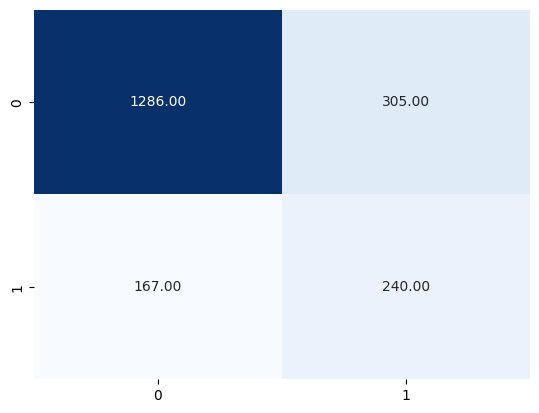

In [42]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_log), annot=True, cbar=False, cmap="Blues", fmt=".2f")

* `RandomForest`

In [43]:
# Using RV with class_weights
forest_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight=dict_weights)
forest_clf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_forest = forest_clf.predict(X_train_final)
y_pred_test_foerst = forest_clf.predict(X_test_final)

# Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_foerst)

print(f'The f1_score using RF model for Training Dataset with class_weights is {score_train_forest*100:.3f}')
print(f'The f1_score using RF model for Testing Dataset with class_weights is {score_test_forest*100:.3f}')

The f1_score using RF model for Training Dataset with class_weights is 59.875
The f1_score using RF model for Testing Dataset with class_weights is 57.540


In [44]:
# RF with SMOTE
forest_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45)
forest_clf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_train_forest = forest_clf.predict(X_train_final)
y_pred_test_forest = forest_clf.predict(X_test_final)

# Using f1_score
score_train_forest = f1_score(y_train, y_pred_train_forest)
score_test_forest = f1_score(y_test, y_pred_test_forest)

print(f'The f1_score using RF model for Training Dataset with SMOTE is {score_train_forest*100:.3f}')
print(f'The f1_score using RF model for Testing Dataset with SMOTE is {score_test_forest*100:.3f}')

The f1_score using RF model for Training Dataset with SMOTE is 61.869
The f1_score using RF model for Testing Dataset with SMOTE is 59.481


* `RF-Tuning`

In [45]:
forest_base_clf = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=45, class_weight=dict_weights)

params_best_grid = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(6, 10, 2)
}
grid_search_forest = GridSearchCV(estimator=forest_base_clf, param_grid=params_best_grid, cv=5, n_jobs=-1, scoring="f1", verbose=4)
grid_search_forest.fit(X_train_final, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.20387984981226537,
                                                            1: 0.7961201501877346},
                                              max_depth=5, n_estimators=150,
                                              random_state=45),
             n_jobs=-1,
             param_grid={'max_depth': array([6, 8]),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350])},
             scoring='f1', verbose=4)

In [46]:
grid_search_forest.best_params_, grid_search_forest.best_score_

({'max_depth': 8, 'n_estimators': 150}, 0.611357564173193)

In [47]:
# The forest after tuning
forest_tuned = grid_search_forest.best_estimator_

# Predict and evaluate
y_pred_train_forest_tuned = forest_tuned.predict(X_train_final)
y_pred_test_forest_tuned = forest_tuned.predict(X_test_final)

# Using f1_score
score_train_forest_tuned = f1_score(y_train, y_pred_train_forest_tuned)
score_test_forest_tuned = f1_score(y_test, y_pred_test_forest_tuned)

print(f'The f1_score using tuned RF model for Training Dataset with class_weigths is {score_train_forest_tuned*100:.3f}')
print(f'The f1_score using tuned RF model for Testing Dataset with class_weigths is {score_test_forest_tuned*100:.3f}')

The f1_score using tuned RF model for Training Dataset with class_weigths is 68.835
The f1_score using tuned RF model for Testing Dataset with class_weigths is 61.057


In [48]:
# dump forest tuned model
joblib.dump(forest_tuned, os.path.join(ARTIFACT_FOLDER_PATH, "forest_tuned.pkl"))

['c:\\Users\\moham\\Desktop\\Round 2\\07- Chrun Full project\\G4\\notebooks\\..\\artifacts\\forest_tuned.pkl']

In [49]:
# Feature Importance
forest_tuned.feature_importances_

array([0.04962274, 0.37439777, 0.09329713, 0.05240497, 0.05372349,
       0.00771584, 0.02389478, 0.06539465, 0.24666409, 0.00587399,
       0.02701055])

In [51]:
# Get the features out from the preprocessor
features_after = [name.split('__')[1] for name in preprocessor.get_feature_names_out()]
features_after

['CreditScore',
 'Age',
 'Balance',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'IsActiveMember',
 'NumOfProducts',
 'HasCrCard',
 'Tenure']

In [52]:
# Feature Importance from RF
forest_tuned_importance = pd.DataFrame({'feature': features_after, 
                            'importance': forest_tuned.feature_importances_}).sort_values('importance', ascending=False)
forest_tuned_importance

,feature,importance
1,Age,0.374398
8,NumOfProducts,0.246664
2,Balance,0.093297
7,IsActiveMember,0.065395
4,Geography_Germany,0.053723
3,EstimatedSalary,0.052405
0,CreditScore,0.049623
10,Tenure,0.027011
6,Gender_Male,0.023895
5,Geography_Spain,0.007716


----

* `XGBOOST`

In [53]:
xgb_base_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators=150, 
                                max_depth=5, random_state=42, learning_rate=0.1)
xgb_base_model.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_train_xgb = xgb_base_model.predict(X_train_final)
y_pred_test_xgb = xgb_base_model.predict(X_test_final)

# Using f1_score
score_train_xgb = f1_score(y_train, y_pred_train_xgb)
score_test_xgb = f1_score(y_test, y_pred_test_xgb)

print(f'The f1_score using XGBoost model for Training Dataset with scale is {score_train_xgb*100:.3f}')
print(f'The f1_score using XGBoost model for Testing Dataset with scale is {score_test_xgb*100:.3f}')

The f1_score using XGBoost model for Training Dataset with scale is 70.484
The f1_score using XGBoost model for Testing Dataset with scale is 60.266


In [61]:
# 1. Using scale_pos_weight
scale = sum(y_train==0) / sum(y_train==1)

# 2. Using sample_weight while fitting
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = class_weights / np.sum(class_weights)
weight_dict = dict(zip(np.unique(y_train), class_weights))
samples_weights = np.array([weight_dict[y] for y in y_train])
samples_weights

array([0.20387985, 0.20387985, 0.20387985, ..., 0.20387985, 0.20387985,
       0.79612015])

* `XGBoost-Tuning using RanomizedSearchCV`

In [63]:
xgb_base_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=5, reg_lambda=5,
                                learning_rate=0.1, n_estimators=150, random_state=4)

# Hyperparameter tuning with class weights
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'n_estimators': [100, 200, 300, 400],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
}

random_search_xgb = RandomizedSearchCV(estimator=xgb_base_model, 
                                    param_distributions=param_dist, 
                                    cv=5, n_jobs=-1, n_iter=25, scoring="f1", random_state=48)
random_search_xgb.fit(X_train_final, y_train, sample_weight=samples_weights)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=150, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=4, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=48, scoring='f1')

In [64]:
# The xgb after tuning
xgb_tuned = random_search_xgb.best_estimator_

# Predict and evaluate
y_pred_train_xgboost_tuned = xgb_tuned.predict(X_train_final)
y_pred_test_xgboost_tuned = xgb_tuned.predict(X_test_final)

# Using f1_score
score_train_xgb_tuned = f1_score(y_train, y_pred_train_xgboost_tuned)
score_test_xgb_tuned = f1_score(y_test, y_pred_test_xgboost_tuned)

print(f'The f1_score using tuned XGBoost model for Training Dataset with scale is {score_train_xgb_tuned*100:.3f}')
print(f'The f1_score using tuned XGBoost model for Testing Dataset with scale is {score_test_xgb_tuned*100:.3f}')

The f1_score using tuned XGBoost model for Training Dataset with scale is 75.223
The f1_score using tuned XGBoost model for Testing Dataset with scale is 61.880


In [66]:
# Dump model
joblib.dump(xgb_tuned, os.path.join(ARTIFACT_FOLDER_PATH, 'xgb_tuned.pkl'))

['c:\\Users\\moham\\Desktop\\Round 2\\07- Chrun Full project\\G4\\notebooks\\..\\artifacts\\xgb_tuned.pkl']